# Sample Average Approximation (SAA)

\begin{equation}
\begin{array}{ll}
\displaystyle \min & 2x_1+3x_2+\mathbb{E}[7y_1(\xi)+12y_2(\xi)], \\
\mbox{s.t.} & x_1 + x_2 \leq 100 \\
            & (2 + \xi_1)x_1 + 6x_2 + y_1(\xi) \leq 180 + \xi_2 \\
            & 3x_1 + (3.4 - \xi_3)x_2 + y_2(\xi) \leq 162 + \xi_4 \\
            & x_1, x_2 \geq 0, y_1(\xi), y_2(\xi) \geq 0\\
\end{array}
\end{equation}

where $\xi = (\xi_1, \xi_2, \xi_3, \xi_4)$. Suppose $\xi_1, \xi_2, \xi_3, \xi_4$ are independent random variables, and

-  $\xi_1 \sim U(-0.8,0.8)$
-  $\xi_2 \sim N(0,12)$
-  $\xi_3 \sim$ exponential(2.5)
-  $\xi_4 \sim N(0,9)$

In [63]:
from gurobipy import *
import numpy 
import math
import matplotlib.pyplot as plt

numscen_list = [10, 50, 100, 200, 500, 1000];  # n
numbatch = 25;  # M
numeval = 100000; # N

candx1 = 0.0
candx2 = 0.0

In [64]:
### function for building and solving the extensive form for a given sample chi1, chi2
### returns the objective value and the solution
def solveEF(chi1, chi2, chi3, chi4):

    ef = Model("extensiveform")
    ef.params.logtoconsole=0
    x1 = ef.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, obj = 2.0)
    x2 = ef.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, obj = 3.0)
    y1 = {}
    y2 = {}
    for j in range(numscen):
        y1[j] = ef.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, obj = 7.0/float(numscen))
        y2[j] = ef.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, obj = 12.0/float(numscen))

    ef.update()
    
    ef.addConstr(x1 + x2 <= 100);

    for j in range(numscen):
        ef.addConstr((2 + chi1[j])*x1 + 6*x2 + y1[j] >= 180 + chi2[j])
        ef.addConstr(3*x1 + (3.4 - chi3[j])*x2 + y2[j] >= 162 + chi4[j])

    ef.modelSense = GRB.MINIMIZE
    ef.update()
    ef.optimize()
    return [ef.objval, x1.x, x2.x]

In [65]:
### function for building and solving the second stage problem for 
#### a given value chi1,chi2,chi3,chi4 and first-stage solution x1,x2
### returns the objective value
def solveSSP(x1val, x2val, chi1, chi2, chi3, chi4):
    y1val = 0.0
    y2val = 0.0
    y1val = max(180 + chi2 - (2 + chi1)*x1val - 6*x2val, 0.0)
    y2val = max(162 + chi4 - 3*x1val - (3.4 - chi3)*x2val, 0.0)
    return 2*x1val + 3*x2val + 7*y1val + 12*y2val

In [66]:
LB_me_seq = []
LB_ci_up_seq = []
LB_ci_low_seq = []

UB_me_seq = []
UB_ci_up_seq = []
UB_ci_low_seq = []

for numscen in numscen_list:
    
    print("****************** Number of Scenarios = ", numscen, "******************\n")
    objvals = numpy.zeros(numbatch)

    ### First separately estimate lower and upper bounds #### 
    for k in range(numbatch):

        ### set up and solve extensive form for a sample average approximation problem
        chi1 = [numpy.random.uniform(-0.8, 0.8) for j in range(numscen)]  # creates numscen scenarios
        chi2 = [numpy.random.normal(0, math.sqrt(12)) for j in range(numscen)] 
        chi3 = [numpy.random.exponential(1/2.5) for j in range(numscen)]
        chi4 = [numpy.random.normal(0, 3) for j in range(numscen)]
        objvals[k], candx1, candx2 = solveEF(chi1, chi2, chi3, chi4) 


    print("Mean SAA Obj value = ", numpy.mean(objvals));
    print("St. Dev of SAA Obj value = ", numpy.std(objvals), "\n");
    lbmean = numpy.mean(objvals)
    LB_me_seq.append(lbmean)
    lbwidth = numpy.std(objvals)/math.sqrt(numbatch)*1.645
    LB_ci_up_seq.append(lbmean - lbwidth)
    LB_ci_low_seq.append(lbmean + lbwidth)

    ### here, candx1 and candx2 are the solution obtained in last batch above
    ### more generally, might want to choose "most promising" solution
    print("Candidate solution = (", candx1, ",", candx2, ")");
    evalvals = numpy.zeros(numeval)
    chi1 = [numpy.random.uniform(-0.8, 0.8) for j in range(numeval)]  # creates numscen scenarios
    chi2 = [numpy.random.normal(0, math.sqrt(12)) for j in range(numeval)] 
    chi3 = [numpy.random.exponential(1/2.5) for j in range(numeval)]
    chi4 = [numpy.random.normal(0, 3) for j in range(numeval)]
    for k in range(numeval):
        evalvals[k] = solveSSP(candx1, candx2, chi1[k], chi2[k], chi3[k], chi4[k]);

    print("Mean Solution Obj. Value = ", numpy.mean(evalvals))
    print("St. Dev of Solution Obj Value = ", numpy.std(evalvals), '\n')
    ubmean = numpy.mean(evalvals)
    UB_me_seq.append(lbmean)
    ubwidth = numpy.std(evalvals)/math.sqrt(numeval)*1.645
    UB_ci_up_seq.append(lbmean - lbwidth)
    UB_ci_low_seq.append(lbmean + lbwidth)

    print("95% CI on lower bound = [", lbmean - lbwidth, ",", lbmean + lbwidth, "]");
    print("95% CI on upper bound = [", ubmean - ubwidth, ",", ubmean + ubwidth, "]\n");

****************** Number of Scenarios =  10 ******************

Mean SAA Obj value =  140.33143548213476
St. Dev of SAA Obj value =  4.9246225480756305 

Candidate solution = ( 38.702988730928695 , 21.015682467715408 )
Mean Solution Obj. Value =  149.25636715795417
St. Dev of Solution Obj Value =  33.7154940663268 

95% CI on lower bound = [ 138.7112346638179 , 141.95163630045164 ]
95% CI on upper bound = [ 149.08098095313827 , 149.43175336277008 ]

****************** Number of Scenarios =  50 ******************

Mean SAA Obj value =  147.18261460380552
St. Dev of SAA Obj value =  4.146538056527766 

Candidate solution = ( 39.682171798426374 , 21.223494182928064 )
Mean Solution Obj. Value =  148.5929958206681
St. Dev of Solution Obj Value =  27.749289545056456 

95% CI on lower bound = [ 145.8184035832079 , 148.54682562440314 ]
95% CI on upper bound = [ 148.44864549407728 , 148.73734614725893 ]

****************** Number of Scenarios =  100 ******************

Mean SAA Obj value =  14

In [67]:
# plot of the final results
intervallist_UB = []
intervallist_LB = []
for i in range(len(UB_me_seq)):
    intervallist_UB.append((UB_ci_low_seq[i], UB_me_seq[i], UB_ci_up_seq[i]))
    intervallist_LB.append((LB_ci_low_seq[i], LB_me_seq[i], LB_ci_up_seq[i]))

Text(0.5, 0, 'Scenarios generated')

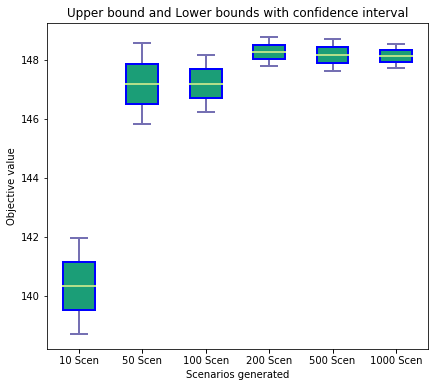

In [68]:
fig = plt.figure(1, figsize=(15, 6))

# Create an axes instance
ax = fig.add_subplot(121)

# Create the boxplot
bp = ax.boxplot(intervallist_LB, patch_artist=True)

for box in bp['boxes']:
    # change outline color
    box.set( color='r', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
    
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

# Create the boxplot for upper bound
bp2 = ax.boxplot(intervallist_UB, patch_artist=True)

for box in bp2['boxes']:
    # change outline color
    box.set( color='b', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
    
## change color and linewidth of the whiskers
for whisker in bp2['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp2['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp2['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp2['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

ax.set_xticklabels(['10 Scen', '50 Scen', '100 Scen', '200 Scen', '500 Scen', '1000 Scen'])

plt.title('Upper bound and Lower bounds with confidence interval')
plt.ylabel('Objective value')
plt.xlabel('Scenarios generated')